# Table of contents

1. [Business Understanding](#Business_Understanding)
2. [Data Understanding](#Data_Understanding)
3. [Prepare Data](#Prepare_Data)
4. [Data Modelling](#Data_Modelling)
5. [Model Evaluation](#Model_Evaluation)

# 1. Business Understanding

In this notebook I am using visualisation tools to assist me in trying to answer important questions about the
AirBnB listsing for London in 2020. The data that i am using is from the [Inside AirBnb](http://insideairbnb.com/get-the-data.html) website.

I will try and answer the following questions:
* What types of verifications are hosts using?
* Which types of amenities are hosts using? Would they give a good review score?
* What could possibly an acceptable price?
* What could be the most important to the price?


# 2. Data Understanding

<a id='Data_Understanding'></a>

### Importing Libraries

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi
from ast import literal_eval

%matplotlib inline

import xgboost as xgb
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, ShuffleSplit, RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Loading Data

In [2]:
# Loading csv file into dataframe
df_listings = pd.read_csv('../data/raw/listings.csv', low_memory=False)

In [3]:
# Number of rows and columns in the dataframe
df_listings.shape

(77136, 74)

In [4]:
# Displaying all columns
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",$105.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",$40.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",$75.00,10,50,10.0,10.0,50.0,50.0,10.0,50.0,

In [5]:
# General statistics of the data
df_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.713600e+04,7.713600e+04,7.713600e+04,77095.000000,77095.000000,0.0,77136.000000,77136.000000,77136.000000,0.0,72284.000000,75992.000000,77136.000000,7.713600e+04,77135.000000,77135.000000,7.713500e+04,7.713500e+04,77135.000000,7.713500e+04,0.0,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,52965.000000,52902.000000,52911.000000,52855.000000,52904.000000,52856.000000,52855.000000,0.0,77136.000000,77136.000000,77136.000000,77136.000000,54705.000000
mean,2.598945e+07,2.020122e+13,9.675921e+07,24.170374,24.170374,NaN,51.510106,-0.128107,3.070006,NaN,1.488587,1.707811,5.180564,2.069624e+04,5.452855,6.908913,1.878365e+05,7.724969e+05,5.979946,7.222697e+05,NaN,11.320590,24.534757,38.320356,122.106046,15.283823,1.583891,0.045439,93.044652,9.525746,9.284270,9.649134,9.669231,9.557212,9.300974,NaN,20.686631,17.525993,2.618259,0.036559,0.607957
std,1.340272e+07,2.074232e+01,1.018449e+08,125.710654,125.710654,NaN,0.047450,0.094877,1.951961,NaN,0.884982,1.284529,22.401630,4.066635e+06,23.192706,30.399336,1.937087e+07,4.037594e+07,25.947365,3.774108e+07,NaN,13.215171,26.900944,40.683909,144.228420,35.440263,4.581973,0.319414,10.531457,1.033406,1.186098,0.931390,0.929136,0.869663,1.077889,NaN,98.922987,96.070725,16.523581,0.509314,0.865626
min,1.155100e+04,2.020122e+13,2.010000e+03,0.000000,0.000000,NaN,51.292570,-0.496870,0.000000,NaN,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.526581e+07,2.020122e+13,1.627615e+07,1.000000,1.000000,NaN,51.484497,-0.188510,2.000000,NaN,1.000000,1.000000,1.000000,3.100000e+01,1.000000,1.000000,9.000000e+01,9.000000e+01,1.000000,9.000000e+01,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.110000
50%,2.623901e+07,2.020122e+13,4.997764e+07,1.000000,1.000000,NaN,51.514230,-0.126040,2.000000,NaN,1.000000,1.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,NaN,0.000000,3.000000,13.000000,57.000000,3.000000,0.000000,0.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,1.000000,0.000000,0.320000
75%,3.816095e+07,2.020122e+13,1.558912e+08,3.000000,3.000000,NaN,51.539340,-0.069387,4.000000,NaN,2.000000,2.000000,3.000000,1.125000e+03,4.000000,4.000000,1.125000e+03,1.125000e+03,4.000000,1.125000e+03,NaN,28.000000,58.000000,88.000000,262.000000,14.000000,1.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,4.000000,2.000000,1.000000,0.000000,0.780000
max,4.707231e+07,2.020122e+13,3.803358e+08,3450.000000,3450.000000,NaN,51.679980,0.288570,16.000000,NaN,50.000000,50.000000,1125.000000,1.000000e+09,1125.000000,1125.000000,2.147484e+09,2.147484e+09,1125.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,817.000000,479.000000,22.000000,100.000000,10.000000,10.

In [6]:
# Dataframe columns information
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77136 entries, 0 to 77135
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            77136 non-null  int64  
 1   listing_url                                   77136 non-null  object 
 2   scrape_id                                     77136 non-null  int64  
 3   last_scraped                                  77136 non-null  object 
 4   name                                          77112 non-null  object 
 5   description                                   74048 non-null  object 
 6   neighborhood_overview                         47437 non-null  object 
 7   picture_url                                   77136 non-null  object 
 8   host_id                                       77136 non-null  int64  
 9   host_url                                      77136 non-null 

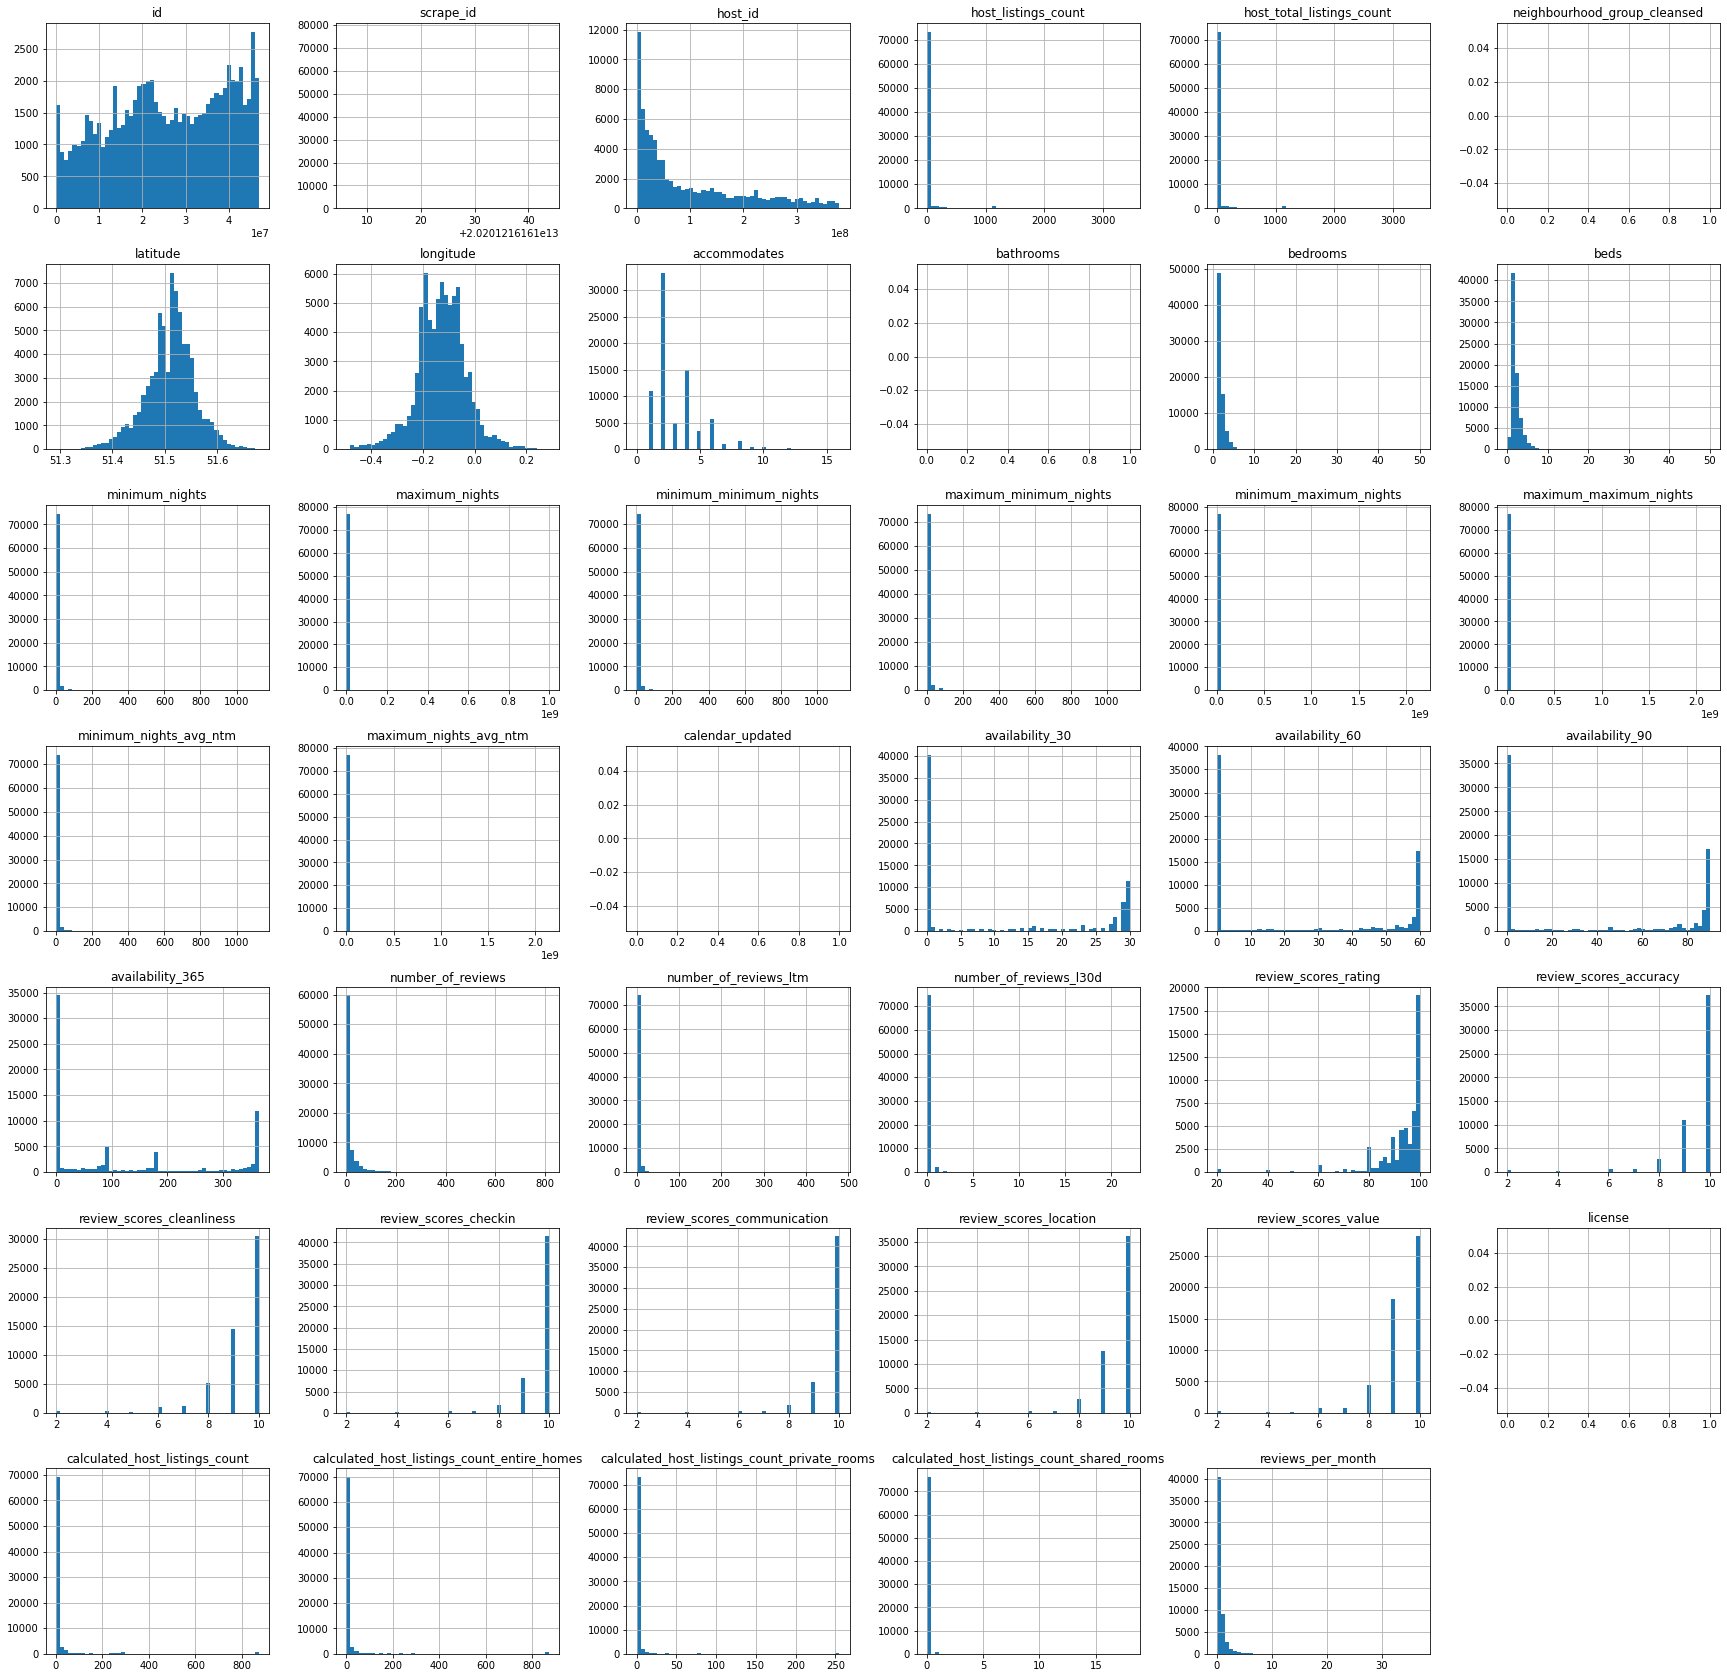

In [7]:
# Checking the distribution of all variables
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

In [8]:
# Finding the columns with more than 75% of values missing
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'bathrooms', 'calendar_updated', 'license', 'neighbourhood_group_cleansed'}

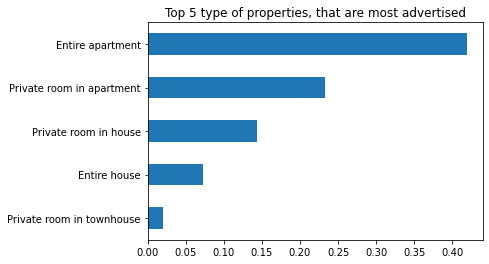

In [9]:
# Exploring the data for number of property types
neighbourhood_vals = df_listings['property_type'].value_counts()

((neighbourhood_vals[0:5]/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("Top 5 type of properties, that are most advertised");

In [10]:
# Checking the property type count above 100
neighbourhood_vals[df_listings['property_type'].value_counts() > 100]

Entire apartment                     32292
Private room in apartment            17926
Private room in house                11111
Entire house                          5618
Private room in townhouse             1529
Entire condominium                    1349
Entire serviced apartment             1026
Entire townhouse                       963
Private room in condominium            656
Private room in bed and breakfast      538
Room in boutique hotel                 458
Entire loft                            428
Room in hotel                          303
Shared room in apartment               294
Room in serviced apartment             293
Private room in loft                   244
Private room in guest suite            189
Entire guest suite                     176
Private room in guesthouse             174
Shared room in house                   131
Entire guesthouse                      121
Room in aparthotel                     118
Room in hostel                         109
Private roo

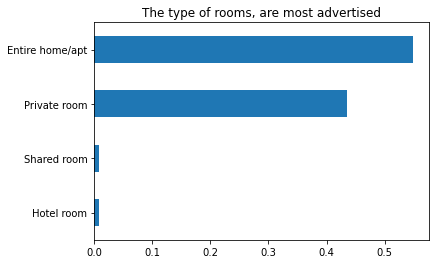

In [11]:
# Exploring the data for number of room types
room_vals = df_listings['room_type'].value_counts()

((room_vals/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("The type of rooms, are most advertised");

In [12]:
# Exploring the data of bathrooms_text
df_listings['bathrooms_text'].value_counts()

1 bath               32520
1 shared bath        14028
2 baths               9175
1 private bath        6014
1.5 baths             5077
1.5 shared baths      3637
2.5 baths             1909
2 shared baths        1367
3 baths               1154
3.5 baths              460
2.5 shared baths       346
4 baths                230
3 shared baths         167
0 shared baths         164
0 baths                154
Half-bath              107
Shared half-bath       105
4.5 baths               91
5 baths                 46
3.5 shared baths        36
Private half-bath       22
6 baths                 21
4 shared baths          20
5.5 baths               20
6 shared baths          19
10 baths                18
6.5 baths                8
4.5 shared baths         8
5 shared baths           7
7 baths                  5
8 baths                  4
8 shared baths           3
8.5 baths                2
7.5 baths                2
7 shared baths           2
11 baths                 1
11.5 baths               1
9

# 3. Prepare Data

<a id='Prepare_Data'></a>

In [13]:
class format_data:
    
    """
    Class for applying a new format to the numerical columns so that they can be explored
    
    data_float function converts object to float
    data_percentage function converts object to percentage
    text_to_int function converts object to integer
    
    Parameters:
    
    Dataframe, "column name"
    
    Returns:
    
    Dataframe
    
    """
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def text_to_int(self):
        self = self.str.split(' ').str[0].replace('Half-bath', '0.5', regex=True) \
                                         .replace('Shared', '0.5', regex=True) \
                                         .replace('Private', '1', regex=True).astype('float')
              
        return self

In [14]:
# Function for finding outliers
def find_outliers(df_listings, column_name):
    
    """
    The function finds outliers and removes them
    from the dataframe.
    
    Parameters:
    
    Dataframe, column_name
    
    Returns:
    
    Dataframe
    
    """
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings[column_name], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings[column_name],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings[column_name] >= Q1 - step) & 
                                  (df_listings[column_name] <= Q3 + step))].sort_values(by=[column_name])
    
    return filtered_data

In [15]:
# Applying format to the price column
float_list = ['price']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [16]:
# Applying format to the host_response_rate and host_acceptance_rate column
percentage_list = ['host_response_rate','host_acceptance_rate']
for x in percentage_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [17]:
# Applying format to the bathrooms_text column
text_list = ['bathrooms_text']
for x in text_list:
    df_listings[x] = format_data.text_to_int(df_listings[x])

In [18]:
# Renaming columns
df_listings.rename(columns={'bathrooms_text': 'bathrooms_shared'}, inplace=True)

In [19]:
# Checking the data is unique for the bathrooms_text
df_listings['bathrooms_shared'].value_counts()

1.0     52584
2.0     10542
1.5      8714
2.5      2255
3.0      1321
3.5       496
0.0       318
4.0       250
0.5       212
4.5        99
5.0        53
6.0        40
5.5        20
10.0       18
6.5         8
7.0         7
8.0         7
9.0         2
8.5         2
7.5         2
12.0        1
11.0        1
17.0        1
35.0        1
11.5        1
10.5        1
Name: bathrooms_shared, dtype: int64

In [20]:
# checking the data is unique for the bedrooms
df_listings['bedrooms'].value_counts()

1.0     49020
2.0     15261
3.0      5196
4.0      1979
5.0       619
6.0       142
7.0        35
8.0        14
10.0        6
11.0        3
9.0         3
12.0        2
50.0        1
16.0        1
22.0        1
19.0        1
Name: bedrooms, dtype: int64

### Removing Outliers

In [21]:
# Applying the find_outliers function 
outliers = find_outliers(df_listings, "price").index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

<AxesSubplot:>

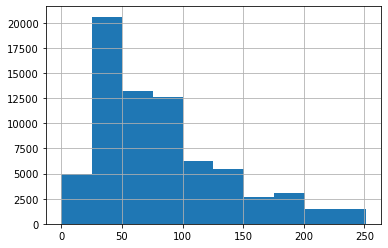

In [22]:
# Checking the new distribution of prices
df_listings["price"].hist()

### Business Questions

<a id='Business_Questions'></a>

In [23]:
def chart_plot(data, x_label, y_label):
    
    """
    Function creates a plot
    
    """
    
    plt.figure(figsize=(10,5))

    sns.set(style="whitegrid")
    chart = sns.barplot(x=x_label, y=y_label, data=data)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=60, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium', 
        rotation_mode='anchor'
    )

In [24]:
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "AirBnB-London-2020"
IMAGES_PATH = "../reports/figures/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    
    """
    Saving image as a png file
    
    """
    
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:
def type_grouping(column):
    
    """
    Create dictionary count
    
    Parameters:
    
    Column name
    
    Returns:
    
    Dictionary
    
    """
    
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict

#### What is the spread of prices using the map of London map? Prices by all year availability?

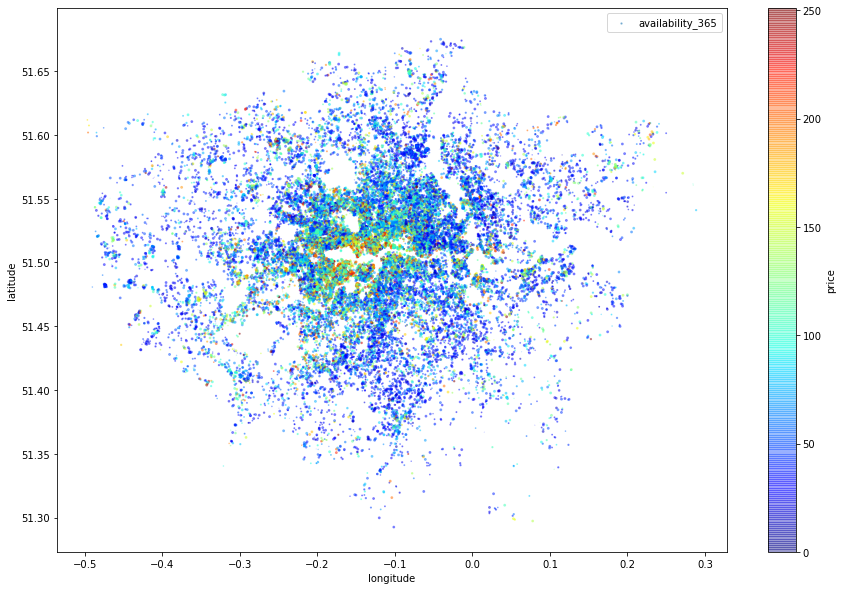

In [26]:
# Initial map of London prices by all year availability
df_listings.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c="price", cmap=plt.get_cmap('jet'), 
                 colorbar=True,
                 sharex=False)
plt.show()

Saving figure availability_365_prices_scatterplot


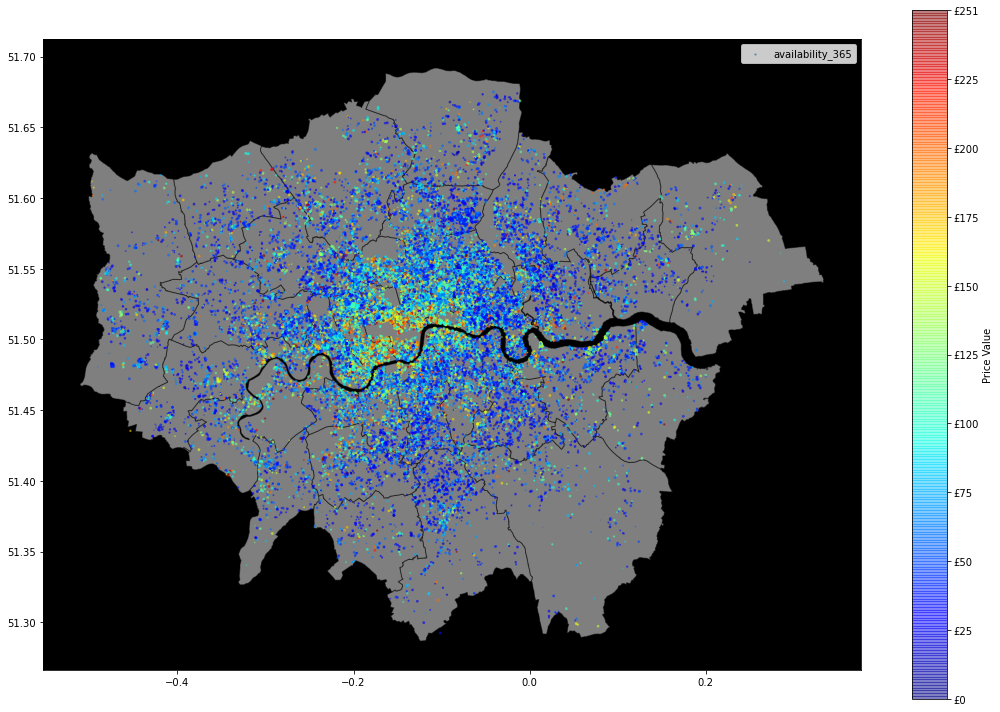

In [27]:
# Completed map of London prices by all year availability
fig, ax = plt.subplots(1, 1, figsize=(15,10))

basemap = gpd.read_file('../data/external/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
basemap = basemap.to_crs(epsg=4326)

basemap = basemap.plot(alpha=0.5, edgecolor='k',color='White',figsize=(15,10),ax=ax)
basemap.set_facecolor('black')


x, y = df_listings['longitude'].values, df_listings['latitude'].values
basemap.scatter(x,y, alpha=0.5,
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c=df_listings["price"], cmap=plt.get_cmap('jet'))


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'))
prices = df_listings["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = fig.colorbar(sm, ticks=tick_values/prices.max(), alpha=0.5)
cbar.ax.set_yticklabels(["£%d"% v for v in tick_values], fontsize=10)
cbar.set_label('Price Value', fontsize=10)

plt.legend(fontsize=10)
save_fig("availability_365_prices_scatterplot")
plt.show()

* What is the average price of the listings, for the different location within London?

In [28]:
# Selecting data where there is a price
price_df = df_listings[df_listings['price'].isnull() == False]

In [29]:
# Showing the top 5 London boroughs by count of listings
price_df['neighbourhood_cleansed'].value_counts()[:5]

Westminster               7218
Tower Hamlets             6659
Hackney                   5592
Camden                    4836
Kensington and Chelsea    4359
Name: neighbourhood_cleansed, dtype: int64

In [30]:
# Grouping data by the London borough and calculating the average price
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [31]:
# Rename the columns 
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'London Broughs','price': 'Avg Price'})

Saving figure Neighbourhood_av_price_histogram_plots


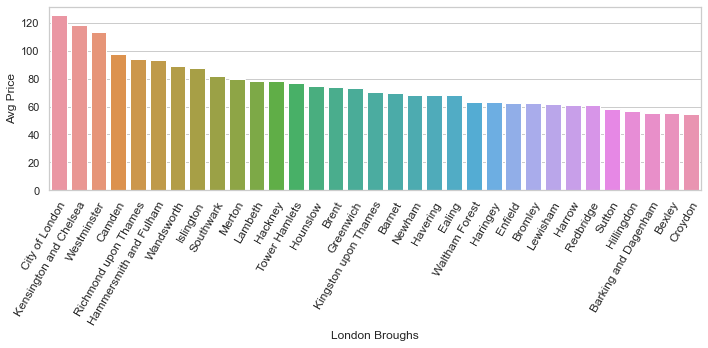

In [32]:
# Applying the chart function and saving the image
chart_plot(nb_price_avg,"London Broughs", "Avg Price")
save_fig("Neighbourhood_av_price_histogram_plots")

#### What types of verifications are hosts using? How long did it take them to respond?

In [33]:
# Removing host_verifications with null values
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False] 

# Removing host_verifications with empyty lists
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [34]:
# Applying the grouping function
verifications_types = type_grouping(verifications_df['host_verifications'])

In [35]:
# Calculating the percentage of Verification Type in the listings
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [36]:
# Creating Verification type dataframe
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
top10_verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)[:10]

Saving figure Verification_type_price_histogram_plots


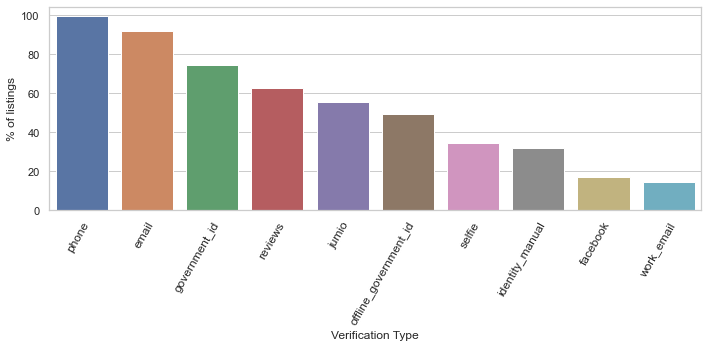

In [37]:
# Creating Verification Type chart and saving to png file
chart_plot(top10_verifications_types,"Verification Type", "% of listings")
save_fig("Verification_type_price_histogram_plots")

#### What amenities are most used and does the amenity affect the review? 

In [38]:
# creating amenities dataframe
df_left = df_listings[['id','amenities']]

In [39]:
# Removing null values
df_left = df_left[df_left['amenities'].notnull()]

In [40]:
# Creating review score dataframe
df_right = df_listings[['id','review_scores_value']]

In [41]:
# Expanding the amenities column
df_left['amenities'] = df_left['amenities'].apply(literal_eval)
df_left = df_left.explode('amenities')

In [42]:
# Merging the custom amenities dataframe with
# the review score dataframe
result = pd.merge(df_left, df_right, on='id')

In [43]:
# Grouping the results by aggregation
result = result.groupby('amenities').agg({'review_scores_value': ['count', 'min', 'max', 'mean']})

In [44]:
# Reseting the index
result = result.reset_index()

In [45]:
# Confirm the layout
result.head().columns

MultiIndex([(          'amenities',      ''),
            ('review_scores_value', 'count'),
            ('review_scores_value',   'min'),
            ('review_scores_value',   'max'),
            ('review_scores_value',  'mean')],
           )

In [46]:
# Renaming the columns by adding the aggregation and
# sorting by the values
result = result.sort_values(by=[('review_scores_value', 'mean'),
                                ('review_scores_value',  'min'),
                                ('review_scores_value',  'max')], ascending=False)

In [47]:
# Removing the "_" from the column name
result.columns = ["_".join(x) for x in result.columns.ravel()]

<ipython-input-47-d6bf43027fca>:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  result.columns = ["_".join(x) for x in result.columns.ravel()]


In [48]:
# Checking the column names
result.head().columns

Index(['amenities_', 'review_scores_value_count', 'review_scores_value_min',
       'review_scores_value_max', 'review_scores_value_mean'],
      dtype='object')

In [49]:
# # Renaming the columns
result.rename(columns={"amenities_":"Amenities", 
                       "review_scores_value_count":"Count Listings",
                       "review_scores_value_min":"Review Min Value",
                       "review_scores_value_max":"Review Max Value",
                       "review_scores_value_mean":"Review Avg Value"}, inplace=True)

In [50]:
# Confirming the layout
result.head()

,Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
2,"14"" TV with Netflix, standard cable",1,10.0,10.0,10.0
4,"19"" HDTV with Netflix, premium cable, Roku",1,10.0,10.0,10.0
5,"20"" HDTV with standard cable",1,10.0,10.0,10.0
9,"28"" HDTV with Netflix, standard cable",1,10.0,10.0,10.0
10,"30"" TV",2,10.0,10.0,10.0


In [51]:
# Filtering the results where count of listings
# is greater than 10
result = result[result['Count Listings'] > 10]

In [52]:
# Formating the results dataframe
result = result.head(20).style.background_gradient() \
               .format({"Amenities": lambda x:x.lower()}) \
               .format({"Review Min Value": "{:20,.2f}"}) \
               .format({"Review Max Value": "{:20,.2f}"}) \
               .format({"Review Avg Value": "{:20,.2f}"}) \
               .hide_index()\
               .background_gradient(cmap='Blues')

In [53]:
# Continued formatting
result.set_properties(subset=["Amenities", 
                              "Count Listings", 
                              "Review Min Value", 
                              "Review Max Value", 
                              "Review Avg Value"], **{'text-align': 'left'}) \
      .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
stainless steel gas stove,21,8.00,10.00,9.81
cleaning products,29,9.00,10.00,9.79
pets allowed,28,9.00,10.00,9.75
clothing storage,11,9.00,10.00,9.73
record player,46,6.00,10.00,9.72
self check-in,158,8.00,10.00,9.71
electric stove,52,8.00,10.00,9.69
bathroom essentials,279,8.00,10.00,9.68
bedroom comforts,279,8.00,10.00,9.68
full kitchen,210,8.00,10.00,9.66


In [54]:
# Exporting the amenities image to a png file
dfi.export(result, '../reports/figures/top_amenities.png')

# 4. Data Modeling

<a id='Data_Modelling'></a>

In [55]:
def drop_columns(df):
    
    """
    Dropping Columns that aren't needed and
    also removing columns with 70% or more of 
    missing data in the column
    
    Parameters:
    
    Dataframe
    
    Returns:
    
    Dataframe
    
    """

    regex_list = ['url','scrape','first_review','last_review','cancellation_policy','requires']
    
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['id','name','description','neighborhood_overview','latitude',
                          'longitude','neighbourhood','calendar_updated','host_id', 'host_name', 
                          'host_since', 'host_location', 'host_about','host_response_time',
                          'host_response_rate', 'host_acceptance_rate', 
                          'host_neighbourhood', 'host_listings_count',
                          'host_has_profile_pic', 'host_identity_verified',
                          'minimum_minimum_nights', 'maximum_nights_avg_ntm',
                          'maximum_minimum_nights', 'minimum_maximum_nights',
                          'maximum_maximum_nights', 'minimum_nights_avg_ntm'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

In [56]:
def onehot_df(df, variable, unique_items):
    
    """
    Creates one hot encoding for the specified column
    using the unique items specified
    
    Parameters:
    
    Dataframe, variable(string), unique_items(list)
    
    Returns:
    
    Dataframe
    
    """
    
    item_lists = df[variable]
    
    # Loop through all the labels
    for i, label in enumerate(unique_items):
        
        # Creating new column for each label
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    
    # Removing old column
    del df[variable]
            
    # Return the results as a dataframe
    return df

In [57]:
def to_1D(series):
    
    """
    Creates a 1D array
    
    Paramters:
    
    Series
    
    Returns:
    
    Array
    
    """
    
    return pd.Series([x for _list in series for x in _list])

In [58]:
# Dropping unwanted columns
df_listings = drop_columns(df_listings)

<AxesSubplot:>

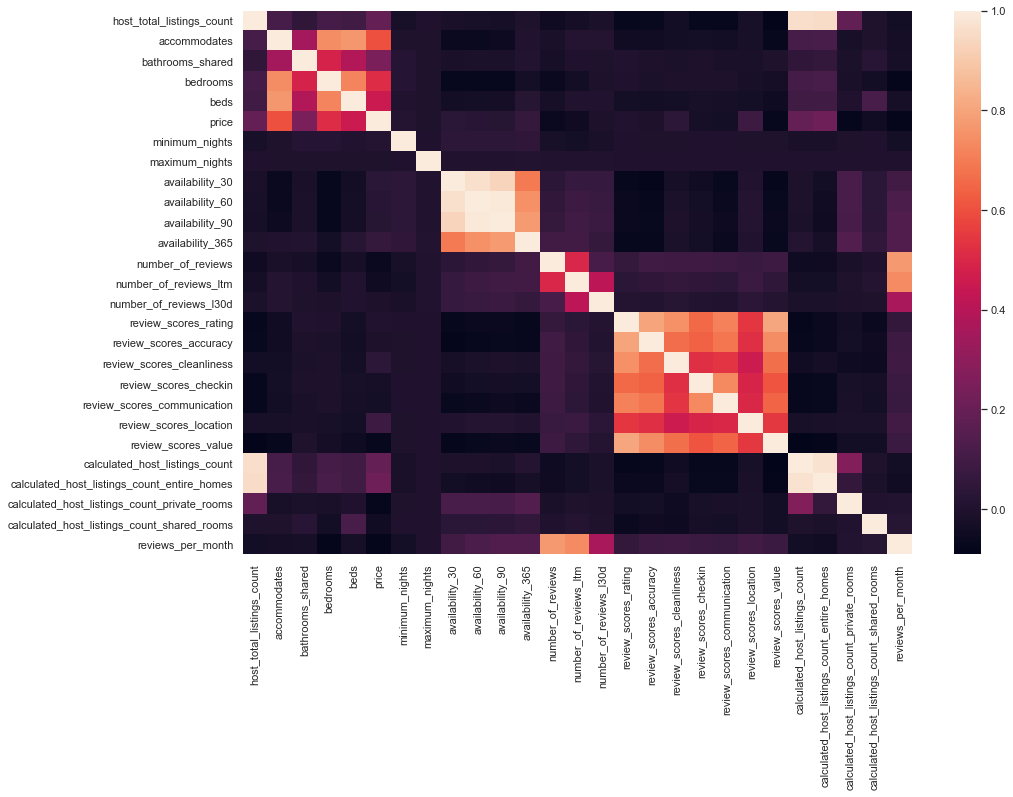

In [59]:
# Finding the columns that have an correlation with the price column
# calculate the correlation matrix
corr = df_listings.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [60]:
# Checking labels for the object type data
for col in df_listings.select_dtypes(include=['object']).columns:
    print(col, ': ', len(df_listings[col].unique()), 'labels')

host_is_superhost :  3 labels
host_verifications :  535 labels
neighbourhood_cleansed :  33 labels
property_type :  89 labels
room_type :  4 labels
amenities :  67099 labels
has_availability :  2 labels
instant_bookable :  2 labels


In [61]:
# Checking Property Type labels
df_property_type = df_listings["property_type"].value_counts()

In [62]:
# Amenities expansion to label encoding
df_listings["amenities"] = df_listings["amenities"].apply(eval)

In [63]:
# host_verifications expansion to label encoding
df_listings["host_verifications"] = df_listings["host_verifications"].apply(eval)

In [64]:
# Creating new features for number of amenities and verification types
df_listings['amenities_len'] = df_listings['amenities'].str.len()
df_listings['verifications_len'] = df_listings['host_verifications'].str.len()

del df_listings['host_verifications']

In [65]:
# Creating new property type column
df_listings["property_type"] = df_listings["property_type"].str.split().str[-1]

In [66]:
# Creating the top 10 amenities
df_amenities_top_10 = pd.DataFrame(to_1D(df_listings["amenities"]).value_counts().head(50)).index

df_amenities_top_10

Index(['Wifi', 'Heating', 'Essentials', 'Kitchen', 'Smoke alarm', 'Washer',
       'Hangers', 'Iron', 'TV', 'Hair dryer', 'Shampoo', 'Dedicated workspace',
       'Carbon monoxide alarm', 'Hot water', 'Dryer', 'Refrigerator',
       'Dishes and silverware', 'Cooking basics', 'Oven', 'Bed linens',
       'Microwave', 'Stove', 'Fire extinguisher', 'First aid kit',
       'Private entrance', 'Dishwasher', 'Long term stays allowed',
       'Coffee maker', 'Free parking on premises', 'Elevator',
       'Lock on bedroom door', 'Extra pillows and blankets', 'Host greets you',
       'Cable TV', 'Luggage dropoff allowed', 'Patio or balcony',
       'Garden or backyard', 'Breakfast', 'Paid parking off premises',
       'Lockbox', 'Free street parking', 'Bathtub', 'Shower gel',
       'Indoor fireplace', 'Single level home', 'Air conditioning',
       'High chair', 'Paid parking on premises', 'Private living room',
       'Children’s books and toys'],
      dtype='object')

In [67]:
# Creating the top 20 property types
df_new_property_top_20 = pd.DataFrame(df_listings["property_type"].value_counts().head(20)).index

df_new_property_top_20

Index(['apartment', 'house', 'townhouse', 'condominium', 'loft', 'breakfast',
       'hotel', 'suite', 'guesthouse', 'hostel', 'bungalow', 'aparthotel',
       'room', 'cottage', 'Boat', 'home/apt', 'villa', 'place', 'cabin',
       'Houseboat'],
      dtype='object')

In [68]:
# Applying the one hot encoding for the top 10 amenities
df_listings = onehot_df(df_listings,"amenities", df_amenities_top_10)

In [69]:
# Applying the one hot encoding for the top 20 property types
df_listings = onehot_df(df_listings,"property_type", list(df_new_property_top_20))

In [70]:
# Confirming the shape of the df_listings
df_listings.shape

(71823, 104)

#### Train / Test split

In [71]:
# Removing any rows with NaN values
df_listings = df_listings.dropna()

In [72]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df_listings = df_listings[df_listings['price'] != 0]

In [73]:
# Extract features and labels
X = df_listings.drop("price", axis=1) # drop labels for training set
y = df_listings["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [74]:
# Applying the train / test split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [75]:
# Confirming the rows and columns are the 
# same for train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32651, 103)
(13994, 103)
(32651,)
(13994,)


#### Creating the data pipeline

In [76]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    """
    A class to select numerical or categorical columns
    
    """
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

In [77]:
# Selecting required dataframe for transformation
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

In [78]:
# Columns of dataframes selected
num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [79]:
# Category pipeline, using one hot encoding
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore')),
    ])

In [80]:
# Number pipeline, adding any missing data with median and 
# applying scaler to the data
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [81]:
# Joining category and numerical pipelines
full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [82]:
# Transforming train and test data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [83]:
# Confiming the layout after transformation
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(32651, 141)
(13994, 141)


# 5. Model Evaluation

<a id='Model_Evaluation'></a>

In [84]:
def base_models(model, X_train, X_test, y_train, y_test):
    
    """
    Function for fitting and predicting with the quired model
    
    Parameters:
    
    model, X_train, X_test, y_train, y_test
    
    Returns:
    
    RMSE
    
    """
    
    start_time = time.time()
   
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predict_train)
    rmse_train = np.sqrt(mse_train)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    
    print("RMSE: Train data " + str(round(rmse_train,2)))

In [85]:
def display_scores(model, X_train, y_train):
    
    """
    Function for applying the cross validation score
    
    Parameters:
    
    model, X_train, y_train
    
    Returns:
    
    RMSE - Scores, Average and Standard Deviation
    
    """
    
    cv = 5
    
    start_time = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())

In [86]:
# "https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

#### Base Evaluation - Fittng the training data with various models

In [87]:
# Linear Regression - Base Model
lm = LinearRegression(n_jobs=-1)
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.025 minutes ---
RMSE: Train data 31.93


In [ ]:
# Ridge Regression - Base Model
ridge = Ridge()
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(n_jobs=-1,random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor(random_state=42)
base_models(grad_booreg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# XGBRegressor - Base Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
base_models(xg_reg, X_train_prepared, X_test_prepared, y_train, y_test)

#### Model with cross-validation

In [ ]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

In [ ]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

In [ ]:
# Gradient Boosting Regressor - CV Model
display_scores(xg_reg, X_train_prepared, y_train)

#### Visualising Train and Test scores by the number of training points

In [ ]:
# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge()
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=5, n_jobs=5)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

# Gradient Boosting Regressor:
title = r"Learning Curves for XGB Regression"
estimator= xgb.XGBRegressor(objective ='reg:squarederror')
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

plt.show()

#### Fine tunning the model

In [ ]:
# Applying GridSearchCV on the extreme gradient boost algorithm
xgb1 = xgb.XGBRegressor()

parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [7, 8, 9],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_prepared,y_train)

In [ ]:
# The best score and paramters
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
# Predicting the prices with the test data
pred_x = xgb_grid.predict(X_test_prepared)

# Calculating the RMSE
mse = mean_squared_error(y_test,pred_x)
rmse = np.sqrt(mse)
rmse

#### Feature Importance

In [ ]:
# Final model and parameters
xgb2 = xgb.XGBRegressor(colsample_bytree = 0.7, 
                        learning_rate = 0.05, 
                        max_depth = 7, 
                        min_child_weight = 4, 
                        n_estimators = 500, 
                        nthread = 4, 
                        objective = 'reg:squarederror', 
                        silent = 1, 
                        subsample = 0.7)

xgb2.fit(X_train_prepared,y_train)

In [ ]:
# feature importance scores
print(xgb2.feature_importances_)

In [ ]:
# ploting the features importance scores
plt.bar(range(len(xgb2.feature_importances_)), xgb2.feature_importances_)
plt.show()

In [ ]:
# Creating all attributes
cat_encoder = full_pipeline.named_transformers_ ["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# Displaying the top ten feature importance scores
sorted(zip(xgb2.feature_importances_,attributes),reverse=True)[:10]